In [10]:
import sys
import os

# Add the path to the directory containing your module
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/data'))
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/losses'))
sys.path.append(os.path.abspath('/projectnb/textconv/dgwave/AudioSCC/models'))

In [11]:
from dataloader_prev_preload import WaveformDatasetPreload
from sampler_prev import RandomConsecutiveSampler
from losses import ConsecutiveDifferenceHigherOrderLossBatch, ConsecutiveDifferenceHigherOrderLoss
from swissarmy_prev import SeqModel


import numpy as np
import torch
from tqdm import tqdm 
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [12]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU.")

Using GPU: Tesla V100-SXM2-16GB


In [46]:
class PairwiseDifferenceLoss(nn.Module):
    def __init__(self, consecutive_size, device):
        super(PairwiseDifferenceLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.device = device

    def forward(self, data, labels):
        batch_size = data.shape[0]
        
        # Expand the tensor to compute pairwise differences
        data_expanded1 = data.unsqueeze(2).expand(batch_size, self.consecutive_size, self.consecutive_size)
        data_expanded2 = data.unsqueeze(1).expand(batch_size, self.consecutive_size, self.consecutive_size)
        
        # Compute differences between data and labels
        data_differences = (data_expanded1 - data_expanded2)

        # Compute differences with the labels
        labels_expanded1 = labels.unsqueeze(2).expand(batch_size, self.consecutive_size, self.consecutive_size)
        labels_expanded2 = labels.unsqueeze(1).expand(batch_size, self.consecutive_size, self.consecutive_size)
        
        label_differences = (labels_expanded1 - labels_expanded2)
        differences = ((data_differences - label_differences)**2)
        # Apply a mask to ignore upper triangle
        mask = torch.triu(torch.ones(self.consecutive_size, self.consecutive_size), diagonal=1).to(self.device)
        differences = differences * (1 - mask).unsqueeze(0)
        
        # Compute the mean to return a scalar loss
        loss = differences.mean()
        
        return loss



In [47]:
def generate_sine_tensor(num_bits, length):
    # Create an array of integers from 0 to length - 1
    t = np.arange(length)
    # Generate the sine waves for each bit
    sine_tensor = np.zeros((length, num_bits))  # Initialize the tensor
    
    for i in range(num_bits):
        frequency = (np.pi / (2 ** i))  # Calculate frequency based on the number of bits
        sine_tensor[:, i] = np.cos(frequency * (t))  # Fill the tensor with sine values

    return sine_tensor

In [48]:
num_bits = 30
max_len = 100_000
seq_bits = 8
seq_max_len = 2
pred_prev = 1
directory = "/projectnb/textconv/dgwave/AudioSCC/data/digits_two/"
terminal_pad = 11
seq_vocab_len = 10

# Sampler setup as before
batch_size = 400
consecutive_size = 40

In [49]:
t_input = torch.tensor(generate_sine_tensor(num_bits,max_len)).float()
print(t_input.shape)

seq_t = torch.tensor(generate_sine_tensor(seq_bits,seq_max_len)).float()
print(seq_t.shape)

torch.Size([100000, 30])
torch.Size([2, 8])


In [50]:
t_input

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e+00,  6.1232e-17,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        ...,
        [-1.0000e+00,  9.2903e-12, -7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [ 1.0000e+00, -1.0000e+00, -5.9268e-12,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.0000e+00, -1.4417e-11,  7.0711e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00]])

In [51]:
seq_t

tensor([[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00],
        [-1.0000e+00,  6.1232e-17,  7.0711e-01,  9.2388e-01,  9.8079e-01,
          9.9518e-01,  9.9880e-01,  9.9970e-01]])

In [52]:
dataset = WaveformDatasetPreload(directory, t_input, max_len, terminal_pad, seq_vocab_len, seq_max_len, seq_t,pred_prev)

 


sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)

# DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler, num_workers=4)

In [53]:
print(dataset.wav_data_list[0].shape)
print(dataset.pred_data_list[0].shape)

torch.Size([1, 27424])
torch.Size([1, 27424, 1])


In [54]:
iteration = 0

for batch in dataloader:
    wav_data, t_step, target, file_idx, seq_inputs, prev_target = batch #right now this wraps arround, just fyi.  not sure its a bad thing.

    print("Waveform data:", wav_data.shape)
    print("Time step:", t_step.shape)
    print("Target tensor:", target.shape)
    print("File index:", file_idx.shape)
    print("File index:", seq_inputs.shape)
    print("Previous Predictions:", prev_target.shape)
    #print(wav_data)
    #print(prev_target)
    iteration = iteration + 1
    if iteration > 10:
        break
    

Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14d4a71577f0><function _MultiProcessingDataLoaderIter.__del__ at 0x14d4a71577f0><function _MultiProcessingDataLoaderIter.__del__ at 0x14d4a71577f0>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()


  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutd

Waveform data: torch.Size([16000, 1])
Time step: torch.Size([16000, 30])
Target tensor: torch.Size([16000, 1])
File index: torch.Size([16000, 2])
File index: torch.Size([16000, 2, 8])
Previous Predictions: torch.Size([16000, 1])
Waveform data: torch.Size([16000, 1])
Time step: torch.Size([16000, 30])
Target tensor: torch.Size([16000, 1])
File index: torch.Size([16000, 2])
File index: torch.Size([16000, 2, 8])
Previous Predictions: torch.Size([16000, 1])
Waveform data: torch.Size([16000, 1])
Time step: torch.Size([16000, 30])
Target tensor: torch.Size([16000, 1])
File index: torch.Size([16000, 2])
File index: torch.Size([16000, 2, 8])
Previous Predictions: torch.Size([16000, 1])
Waveform data: torch.Size([16000, 1])
Time step: torch.Size([16000, 30])
Target tensor: torch.Size([16000, 1])
File index: torch.Size([16000, 2])
File index: torch.Size([16000, 2, 8])
Previous Predictions: torch.Size([16000, 1])
Waveform data: torch.Size([16000, 1])
Time step: torch.Size([16000, 30])
Target tens

In [55]:

config = {
    't_seq_bits': seq_bits,  # Example value for the input bit size
    't_seq_len': seq_max_len,    # Example value for the sequence length
    't_bits': num_bits,      # Example value for the bits used in the decoder

    'encoder': {
        't_layer_dim': 0,               # Example hidden layer dimension for encoder
        't_num_layers': 0,                # Example number of layers in the encoder's initial layer
        'fc_layers': 10,                   # Example number of fully connected layers in the encoder
        'encoder_layers': 2,              # Example number of encoder layers
        'one_hot_vocab_len': 10,          # Vocabulary size for one-hot encoding
        'one_hot_embedding_dim': 100       # Embedding dimension for one-hot encoding
    },

    'decoder': {
        't_layer_dim': 0,                # Example hidden layer dimension for decoder
        't_num_layers': 0,                # Example number of layers in the decoder's initial layer
        'fc_layers': 10,                   # Example number of fully connected layers in the decoder
        'decoder_layers': 1,                # Example number of decoder layers
        'pred_prev_dim': pred_prev
    },

    'output': {
        'mse_output_layers': 4,           # Number of layers in the MSE output head
        'mse_dim': 128,                     # Hidden dimension for the MSE output head
        'bce_output_layers': 1,            # Number of layers in the BCE output head
        'bce_dim': 1                      # Hidden dimension for the BCE output head
    }
}


In [56]:
model = SeqModel(config)

In [57]:
model.to(device)

SeqModel(
  (encoder): SeqEncoder(
    (initial_layer): SwissArmyLayer(
      (t_layers): ModuleList()
      (embedding): Embedding(11, 100, padding_idx=10)
      (layers): ModuleList(
        (0): Linear(in_features=108, out_features=108, bias=True)
        (1): Linear(in_features=108, out_features=108, bias=True)
        (2): Linear(in_features=108, out_features=108, bias=True)
        (3): Linear(in_features=108, out_features=108, bias=True)
        (4): Linear(in_features=108, out_features=108, bias=True)
        (5): Linear(in_features=108, out_features=108, bias=True)
        (6): Linear(in_features=108, out_features=108, bias=True)
        (7): Linear(in_features=108, out_features=108, bias=True)
        (8): Linear(in_features=108, out_features=108, bias=True)
        (9): Linear(in_features=108, out_features=108, bias=True)
      )
    )
    (encoder_layers): ModuleList(
      (0): SwissArmyLayer(
        (t_layers): ModuleList()
        (embedding): Embedding(11, 100, padding

In [58]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
prev_target_list = []
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(consecutive_size,order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(consecutive_size,order=3)
pd_loss = PairwiseDifferenceLoss(consecutive_size, device)

num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    #for batch in dataloader:
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        wav_data, t_step, target, file_idx, seq_inputs, prev_target = batch
        wav_data = wav_data.to(device)
        t_step = t_step.to(device)
        target = target.to(device)
        file_idx = file_idx.to(device)
        seq_inputs = seq_inputs.to(device)
        prev_target = prev_target.to(device) ##add noise here
        bce_output, mse_output = model(seq_inputs,file_idx,t_step,prev_target)
        # Compute losses
        #mse_loss = mse_loss_fn(mse_output*target, wav_data)  # Assuming the target is for MSE # is this accomplishing what i want?
        #bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        #cdif = cdif_loss(mse_output*target, wav_data)
        #bc = bc_loss(outputs, targets)
        #cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        pd = pd_loss(mse_output*target, wav_data)
        
        # Combine losses (you can weight them if needed)
        total_loss = pd
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
    # Print progress for each epoch
    #print(f"Epoch {epoch+1}/{num_epochs} MSE: {mse_loss.item():.6f} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f}  Total Loss: {total_loss.item():.8f}")
    print(f"Epoch {epoch+1}/{num_epochs} PDLoss: {pd.item():.6f}")
    torch.save(model, "new_loss_1.pth")
print("all done sweetheart <3")

Epoch 1/1:   0%|          | 0/2810 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14d4a71577f0><function _MultiProcessingDataLoaderIter.__del__ at 0x14d4a71577f0><function _MultiProcessingDataLoaderIter.__del__ at 0x14d4a71577f0>


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
            self._shutdown_workers()self._shutdown_workers()self._shutdown_workers()


  File "/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/to

Epoch 1/1 PDLoss: 0.000000
all done sweetheart <3


In [59]:
##i need inference and then a noise term for the training prev_pred input.  
model = torch.load("new_loss_1.pth")
model.eval()

SeqModel(
  (encoder): SeqEncoder(
    (initial_layer): SwissArmyLayer(
      (t_layers): ModuleList()
      (embedding): Embedding(11, 100, padding_idx=10)
      (layers): ModuleList(
        (0): Linear(in_features=108, out_features=108, bias=True)
        (1): Linear(in_features=108, out_features=108, bias=True)
        (2): Linear(in_features=108, out_features=108, bias=True)
        (3): Linear(in_features=108, out_features=108, bias=True)
        (4): Linear(in_features=108, out_features=108, bias=True)
        (5): Linear(in_features=108, out_features=108, bias=True)
        (6): Linear(in_features=108, out_features=108, bias=True)
        (7): Linear(in_features=108, out_features=108, bias=True)
        (8): Linear(in_features=108, out_features=108, bias=True)
        (9): Linear(in_features=108, out_features=108, bias=True)
      )
    )
    (encoder_layers): ModuleList(
      (0): SwissArmyLayer(
        (t_layers): ModuleList()
        (embedding): Embedding(11, 100, padding

In [60]:
def sequential_inf(digits,pred_prev,seq_t,t_input,model,device,num_inferences = 20_000,):
    model.eval()
    #encode the sequence:
    file = [int(char) for char in digits] 
    file = file + [10] * (2 - len(file))
    file = torch.tensor(file)
    file = file.unsqueeze(0)
    file = file.to(device)
    #encoder t
    input_seq_t = seq_t
    input_seq_t = input_seq_t.unsqueeze(0)
    input_seq_t[len(digits):] = 0
    input_seq_t = input_seq_t.to(device)
    #initial prev
    prev_target = torch.tensor([[0.0]*pred_prev]) 
    prev_target = prev_target.to(device)
    
    mse_output = torch.zeros(num_inferences, 1).to(device)  # Shape (batch, 1)
    bce_output = torch.zeros(num_inferences, 1).to(device) 
    
    for i in range(num_inferences):
        #print(i)
        t_input_eval = t_input[i].to(device)
        t_input_eval = t_input_eval.unsqueeze(0)
        
        cont_output, wave_output = model(input_seq_t,file,t_input_eval,prev_target)
        
        mse_output[i, 0] = wave_output.item()  # Assuming wave_output is a tensor of shape (1, 1)
        bce_output[i, 0] = cont_output.item() 
        
        prev_target = torch.cat((prev_target,wave_output),dim = -1)
        prev_target = prev_target[:,1:]

    return bce_output, mse_output  
    

In [61]:
from scipy.io import wavfile
file_path = '/projectnb/textconv/dgwave/AudioSCC/data/data_files/011.wav'
sample_rate, data_test = wavfile.read(file_path)
sample_rate

24000

In [62]:
b,m = sequential_inf("01",pred_prev,seq_t,t_input,model,device)

In [63]:
m.shape

torch.Size([20000, 1])

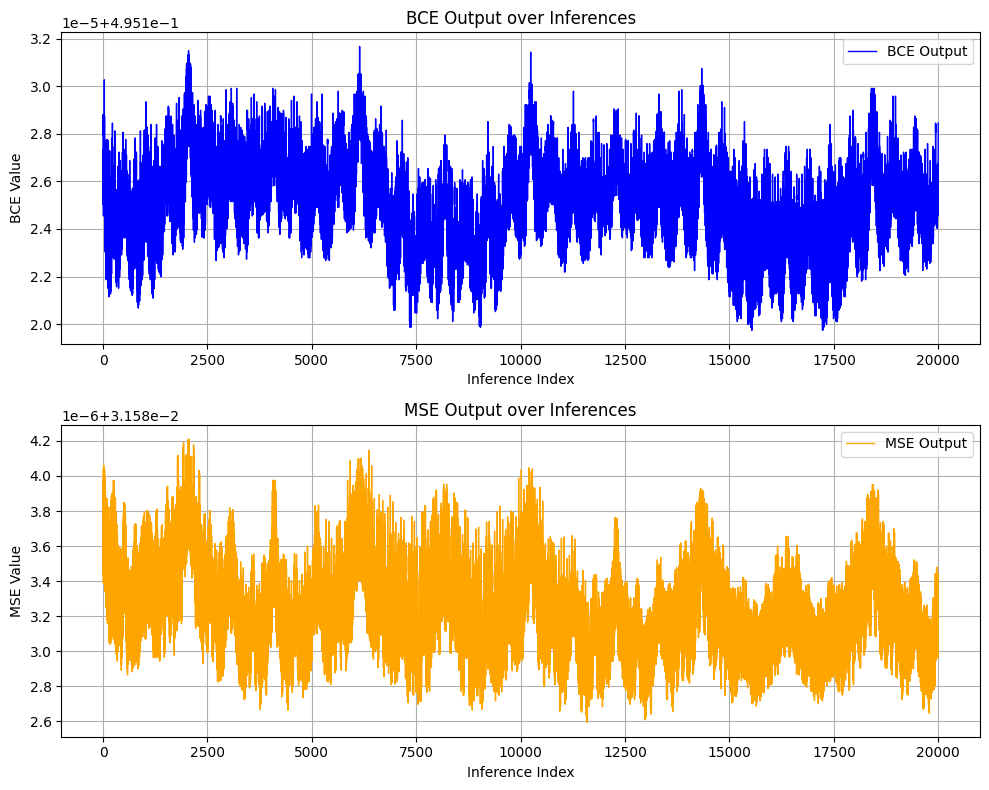

In [64]:
import matplotlib.pyplot as plt

def plot_outputs(bce_output, mse_output):
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # Plot BCE output
    axs[0].plot(bce_output.cpu().numpy(), label='BCE Output', color='blue', linewidth=1)
    axs[0].set_title('BCE Output over Inferences')
    axs[0].set_xlabel('Inference Index')
    axs[0].set_ylabel('BCE Value')
    axs[0].grid()
    axs[0].legend()

    # Plot MSE output
    axs[1].plot(mse_output.cpu().numpy(), label='MSE Output', color='orange', linewidth=1)
    axs[1].set_title('MSE Output over Inferences')
    axs[1].set_xlabel('Inference Index')
    axs[1].set_ylabel('MSE Value')
    axs[1].grid()
    axs[1].legend()

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

plot_outputs(b, m)


In [65]:
import torch
import numpy as np
from scipy.io.wavfile import write


def tensor_to_wav(tensor, filename, sample_rate=44100,cut_off=-1 ):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()[:cut_off]
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data * 32768)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")



In [ ]:
# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(m, "first_out_1.wav",sample_rate)

In [ ]:
from IPython.display import Audio

# Play the .wav file
Audio("first_out_1.wav")